In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("vipoooool/new-plant-diseases-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'new-plant-diseases-dataset' dataset.
Path to dataset files: /kaggle/input/new-plant-diseases-dataset


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from pathlib import Path
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Paths
data_path = Path('/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)')
image_path = data_path / 'New Plant Diseases Dataset(Augmented)'
train_dir = image_path / 'train'
valid_dir = image_path / 'valid'
test_dir = Path("/kaggle/input/new-plant-diseases-dataset/test")
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])
val_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

valid_dataset = datasets.ImageFolder(root= valid_dir, transform=val_transform)
valid_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = datasets.ImageFolder(root= test_dir, transform=val_transform)
test_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

class_names = train_dataset.classes
print("Classes:", class_names)

Classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___

In [4]:
from torchvision.models import densenet121
dense_net = densenet121(weights="DEFAULT")

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 200MB/s]


In [5]:
dense_net

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [6]:
for param in dense_net.features.parameters():
  param.requires_grad = False
  dense_net.classifier = nn.Sequential(
      nn.Linear(1024,512),
      nn.ReLU(),
      nn.Dropout(0.5),
      nn.Linear(512, 256),
      nn.ReLU(),
      nn.Dropout(0.5),
      nn.Linear(256,38)
  )

In [7]:
dense_net = dense_net.to(device)
learning_rate = 0.0005
epochs = 5
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(dense_net.classifier.parameters(), lr = learning_rate)

In [8]:
losses = []
val_losses = []
for epoch in range(epochs):
    # --- Training ---
    dense_net.train()
    train_loss = 0
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = dense_net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_dataloader)
    losses.append(avg_train_loss)
    # --- Validation ---
    dense_net.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in valid_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = dense_net(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_val_loss = val_loss / len(valid_dataloader)
    val_accuracy = correct / total
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}, Val Acc={val_accuracy:.4f}")


Epoch 1: Train Loss=1.2928, Val Loss=0.4547, Val Acc=0.8635
Epoch 2: Train Loss=0.6976, Val Loss=0.3526, Val Acc=0.8899
Epoch 3: Train Loss=0.6187, Val Loss=0.3107, Val Acc=0.9056
Epoch 4: Train Loss=0.5714, Val Loss=0.2994, Val Acc=0.9070
Epoch 5: Train Loss=0.5500, Val Loss=0.2741, Val Acc=0.9141


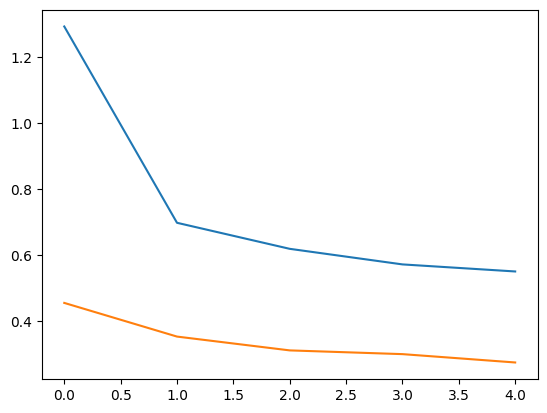

In [9]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.plot(val_losses)
plt.show()

In [10]:
import torch
dense_net.to(device)
dense_net.eval()  # Set model to evaluation mode

correct = 0
total = 0
with torch.no_grad():  # No need to calculate gradients
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = dense_net(images)
        _, predicted = torch.max(outputs, 1)  # Get the class with highest score
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


Test Accuracy: 91.54%
